# Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.dates as md
import datetime

import os
from glob import glob

# Global Variables

In [25]:
directoriesList = ["C:/Users/T-Gamer/Documents/Projetos - Git/FinalCourseAssignment/Dataset/20171203/"]
filesDelimiter  = '\t'
window_size     = 5

pothole_output   = 1
speedbump_output = 2
default_output   = 0

# Functions 

In [3]:
def getFilesFromDirectories(directories, filetype = "csv", pattern = "*."):
    files     = []
    _pattern   = pattern + filetype
    
    try:
        for directory in directories:
            for dir,_,_ in os.walk(directory):
                files.extend(glob(os.path.join(dir, _pattern)))
    except:
        print("\nProblem to get files from directories. Do you do \"import os\" and \"from glob import glob\" ?")
        
    return files


def windowNormalization (serie, window_size):
    #elems     = np.zeros(len(serie) - window_size)
    elems     = np.zeros(len(serie))
    pos_begin = pos_end = 0
    media     = std = 0.0
    count     = 0
    
    while count <= (len(elems) - window_size):
        
        #Is the process at the end?
        if (count + window_size == len(elems)):
            aux = count - 1
            while count < len(elems):
                elems[count] = elems[aux]
                count +=1
            break
            
        pos_end = pos_begin + window_size
        media   = np.mean(serie[pos_begin:pos_end])
        std     = np.std (serie[pos_begin:pos_end])
        
        elems[pos_begin] += np.sqrt((serie[pos_end] - media)**2/std)

        count     +=1
        pos_begin +=1
    
    return elems.tolist()
    
    
def fullNormalization(serie):
    media = np.mean(serie)
    std   = np.std(serie)
    
    return np.sqrt((serie - media)**2/std)



def plotTooltipBokeh(axisSensor, dataframe, dataframe_pothole,dataframe_speedBump, _color = 'red', pos_df_pothole = 15, pos_df_speedBump = 18):
    from bokeh.models   import HoverTool, BoxZoomTool,UndoTool, SaveTool
    from bokeh.charts   import Line
    from bokeh.plotting import output_notebook, show
    from bokeh.models   import  BasicTickFormatter

    output_notebook()
    
    data      = {axisSensor: dataframe[axisSensor].tolist()}
    index     = dataframe['timestamp'].tolist()
    dataframe = pd.DataFrame(data=data, index=index)
    dataframe = dataframe.assign(x=dataframe.index)
    columns   = dataframe.columns.values.tolist()
    columns.remove('x')

    dataframe_pothole['Pothole occurrence']     = pos_df_pothole
    dataframe_speedBump['SpeedBump occurrence'] = pos_df_speedBump

    hover = HoverTool(
            tooltips=[
                ("lineNumberFile", "$index"),
                ("Timestamp, accelerometer", "($x{int}, $y)")
            ]
        )

    # Dados dos Sensores
    p = Line(data = dataframe, x ='x', legend = False,
             title="AXIS " + axisSensor[-1] + " - ACCELEROMETER",
             xlabel='Timestamp', ylabel='m/s^2',
             width=950, height=400, color=_color,
             notebook=True, tools = [hover,BoxZoomTool(),UndoTool(),SaveTool()])

    p.y_range.end   = 25
    p.x_range.start = dataframe['x'].iloc[0] - 10
    p.x_range.end   = dataframe['x'].iloc[-1]+ 1000

    # Pothole
    p.circle(dataframe_pothole['timestamp'].tolist(), dataframe_pothole['Pothole occurrence'].tolist(),fill_color="white",size=8)

    # SpeedBump
    p.inverted_triangle(dataframe_speedBump['timestamp'].tolist(), dataframe_speedBump['SpeedBump occurrence'].tolist(),size=8, color="#DE2D26")

    p.xaxis.formatter=BasicTickFormatter(use_scientific=False)
    show(p)

# Code

In [4]:
# Get Paths from specific file
speedbumpPath = getFilesFromDirectories(directoriesList, pattern = "SpeedBump_InicioAsfaltoVelhoAteRodovia*.")[0]
potholePath   = getFilesFromDirectories(directoriesList, pattern = "Pothole_InicioAsfaltoVelhoAteRodovia*.")[0]
generalPath   = getFilesFromDirectories(directoriesList, pattern = "InicioAsfaltoVelhoAteRodovia*.")[0]

In [24]:
# Reading csv files
df_general    = pd.read_csv(generalPath, delimiter   = filesDelimiter)
df_pothole    = pd.read_csv(potholePath, delimiter   = filesDelimiter)
df_speedbump  = pd.read_csv(speedbumpPath, delimiter = filesDelimiter)

In [56]:
# New data columns from df_general normalization
df_general['accelerometer_normX'] = windowNormalization(df_general['accelerometer_X'], window_size)
df_general['accelerometer_normY'] = windowNormalization(df_general['accelerometer_Y'], window_size)
df_general['accelerometer_normZ'] = windowNormalization(df_general['accelerometer_Z'], window_size)

In [26]:
# Build output column values
df_general.loc[df_general['timestamp'].isin(list(df_pothole['timestamp'])), 'output']   = pothole_output
df_general.loc[df_general['timestamp'].isin(list(df_speedbump['timestamp'])), 'output'] = speedbump_output

df_general['output'] = df_general['output'].fillna(default_output)

In [14]:
#plotTooltipBokeh('accelerometer_Y', df_general, df_pothole,df_speedbump,'red',20,22)

[]

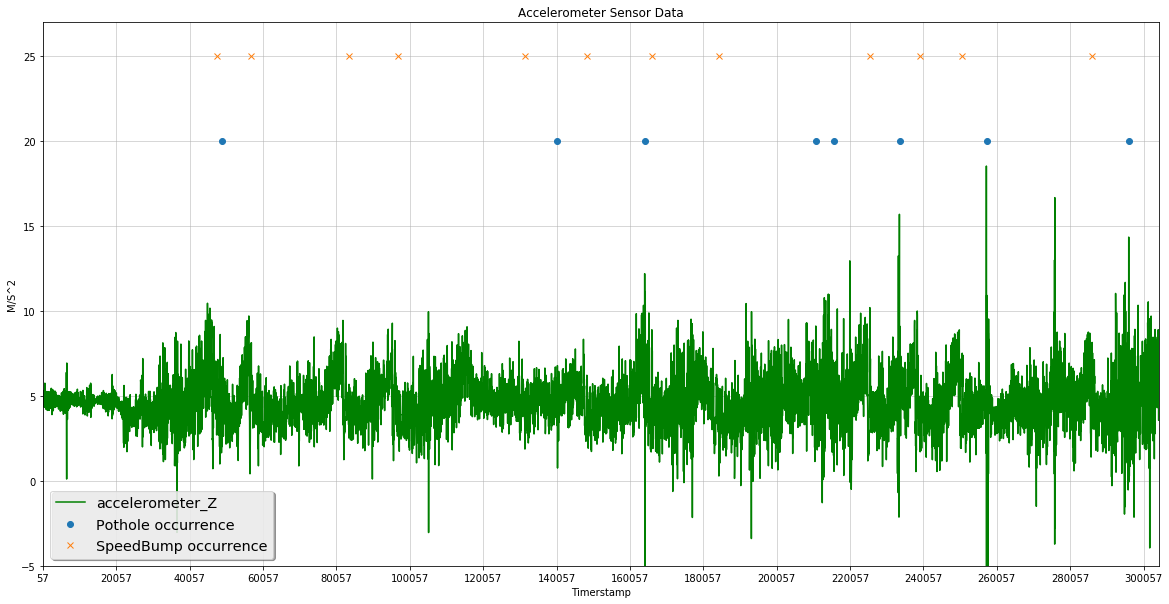

In [50]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(df_general['timestamp'],df_general['accelerometer_Z'], 'g-')

df_pothole['Pothole occurrence'] = 20
df_speedbump['SpeedBump occurrence'] = 25
ax.plot(df_pothole['timestamp'],df_pothole['Pothole occurrence'], 'o')
ax.plot(df_speedbump['timestamp'],df_speedbump['SpeedBump occurrence'], 'x')

#ax.legend(loc='lower left',bbox_to_anchor=(1.1, 0.5),fontsize='x-large')
ax.legend(loc='lower left',fontsize='x-large',shadow = bool)
ax.set_ylabel('M/S^2')
ax.set_xlabel('Timerstamp')
ax.set_title('Accelerometer Sensor Data')
ax.grid(True,linewidth=0.5,linestyle='-')
ax.set_xticks(np.arange(df_general['timestamp'].min(),df_general['timestamp'].max(), 20000))
ax.set_xlim([df_general['timestamp'].min(), df_general['timestamp'].max()])
ax.set_ylim([-5,27])
ax.plot()